# Notebook for Running Ensemble Correlations

## August 31, 2017

Jacob Portes, j.portes@columbia.edu

<p> Note that the first cell is identical to the EnsembleCorrelationFunctions.py file </p>



In [1]:
"""
EnsembleCorrelationFunctions.py

A small part of the Non Visually Responsive Cell Project
Dynamic Brain Workshop, Friday Harbor WA
August 29, 2017
last update: Aug 31 6:45 pm
Jacob Portes, j.portes@columbia.edu

The following code implements the ensemble correlation algorithm outlined in 
the paper Visual stimuli recruit intrinsically generated cortical ensembles 
Jae-eun Kang Miller, Inbal Ayzenshtat, Luis Carrillo-Reid, and Rafael Juste 
(PNAS 2014). The following language is taken from this paper.

The similarity between ensembles was evaluated using: (1) Pearson correlation r
(2) Fisher transform of r

A threshold for significant correlation was established for each pairwise 
comparison. Establishing a threshold for each comparison is important because 
in binary data the number of active neurons in a frame influences a correlation
 coefficient between a pair of frames.
 
1. We generate 1,000 independent surrogate ensembles by randomizing active 
cells while preserving the number of active cells per frame in ONE of the 
frames in each comparison (shuffling across cells).

2. The threshold corresponding to a significance level of P less than 0.05 was 
estimated as the correlation coefficient that exceeded only 5% of 
correlation coefficients between these surrogate ensembles 
(using np.percentile)
"""

# AWS
# drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

# We need to import these modules to get started
import numpy as np
import pandas as pd
import timeit
import os
import sys
import h5py
import matplotlib.pyplot as plt

#--------------------------------------------------------------#
# Generate Threshold for Each Ensemble Comparison
# for a single comparison, generate surrogate by shuffling
#--------------------------------------------------------------#
def generate_threshold_surrogate(ens_a,ens_b,permute_num,percent):

    surr_corr = np.zeros(permute_num)

    for k in range(permute_num):
        tmp_perm = np.random.permutation(ens_b) # permute one ensemble while keeping other stable
        r = np.corrcoef(ens_a,tmp_perm)[0,1] # Pearson Correlation
        surr_corr[k] = 0.5*np.log((1+r)/(1-r)) # Fisher z transform
    
    thresh_final = np.percentile(surr_corr,percent) # percentile function
            
    return thresh_final # return bound for Fisher z transform


#--------------------------------------------------------------#
# Calculate Correlations within a set of ensembles
#--------------------------------------------------------------#
def correlations_between_ensembles(ensemble_array,surr_num,percentile,verbose=False):
    
    '''
    THIS FUNCTION LOOKS FOR CORRELATIONS WITHIN A SET OF ENSEMBLES
    
    Parameters
    -----------
    ensemble_array: numpy array. There should be no empty ensembles
        [cells, ensembles (binarized, ordered)]
    
    surr_num: int
        Number of desired surrogate ensembles
        
        
    Returns
    -----------
    ensemble_matrix:
        Return matrix of ensemble pairs above threshold
        size rows-->cells, cols-->ensembles, but in pairs!
        
    above_thresh_ensembles_boot: 
        Indices of coupled pairs, numpy arrayof pair indices (2 columns)
        
    z_values_boot:
        Fisher-z values of selected ensembles
    '''
    
   

    if verbose:
        print 'verbose = True'
        
        # Plot ensemble matrix
        fig1, ax1 = plt.subplots() # can change figsize=(10,10)
        plt.imshow(ensemble_array,aspect='auto')
        plt.title('All Ensembles',fontsize=18)
        plt.ylabel('cell #', fontsize=14)
        plt.xlabel('ensemble #', fontsize=14)
        plt.show()

    cell_len = ensemble_array.shape[0]
    num_ensembles = ensemble_array.shape[1]
    
    # So I think I have a good way to pull out all the combinations 
    # by using meshgrid and taking the upper triangle
    # Create meshgrid
    tmp_lin = np.linspace(0,num_ensembles-1,num_ensembles) # 0 1 2 3...num_ensembles-1
    x_ind, y_ind = np.meshgrid(tmp_lin,tmp_lin)
    # Get indices of upper triangle, ignore central diagonal. This gives (1,0) (1,2) etc. but not (1,1) or (0,1) etc.
    ind_triu1 = np.triu_indices(num_ensembles,1) 
    
    # Choose value pairs in upper triangle
    xv = x_ind[ind_triu1].astype(int) # make sure these are ints and not floats
    yv = y_ind[ind_triu1].astype(int) 
    
    # Combine them into tuples
    xvyv_zip = zip(xv,yv) 
    
    if verbose:
        # Show zip
        print('Total number of permutations ',xv.shape)
        #print('zip permutations example of first 300: ', xvyv_zip[:300])
    
    # Calculate Pearson Correlation Coefficient
    R = [np.corrcoef(ensemble_array[:,i],ensemble_array[:,j])[0,1] for i,j in zip(xv,yv)]
    R = np.array(R)
    
    # Fisher transform all the correlation coefficients
    R[R == 1] = 1 - sys.float_info.epsilon # to avoid division by 0 and log(0) if R = 1
    R[R == -1] = -1 + sys.float_info.epsilon
    F = 0.5*np.log((1+R)/(1-R)) # what if R == 1?

    if verbose:
        # Plot R values
        fig2, ax2 = plt.subplots()
        plt.subplot(121)
        plt.plot(R,'g')
        plt.title('R Values')
        plt.ylim([-1,1])
        plt.show
        
        # Plot z-Fisher transform
        plt.subplot(122)
        plt.plot(F,'b')
        plt.title('Fisher z Values')
        plt.ylim([-1,1])
        plt.show()
    
    
    start_time = timeit.default_timer()
    
    ## Now Bootstrap with surrogate datasets!
    # Generate threshold for each comparison and store
    F_lower_thresh = [generate_threshold_surrogate(ensemble_array[:,i],ensemble_array[:,j],surr_num,percentile) for i,j in zip(xv,yv)]
    
    elapsed = timeit.default_timer() - start_time
    print('Elapsed surrogate time (s): ', elapsed)
    
    z_values_boot = F[F > F_lower_thresh]
    thresh_ind_boot = np.where(F > F_lower_thresh)[0] # note that this is 1D
    above_thresh_ensembles_boot = np.array(xvyv_zip)[[thresh_ind_boot]]
    
    if verbose:
        print ''
        print('Pairs above threshold (z): ',above_thresh_ensembles_boot.shape)
        #print above_thresh_ensembles_boot.T
        print ''
        print('Fisher-z values above threshold: ',z_values_boot.shape)
        #print z_values_boot
    
    # Flatten pairs that are above threshold
    tmp_flatten = above_thresh_ensembles_boot.flatten()
    
    # Pull out ensemble pairs, save in matrix
    ensemble_matrix = np.zeros((cell_len,len(tmp_flatten)))
    for i in range(len(tmp_flatten)):
        ensemble_matrix[:,i] = ensemble_array[:,tmp_flatten[i]]
        
        
        
    if verbose:
        # Plot correlated ensemble pairs
        fig3, ax3 = plt.subplots(figsize=(10,5))
        plt.imshow(ensemble_matrix,aspect='auto')
        plt.title('Correlated Ensemble Pairs',fontsize=18)
        plt.ylabel('cell #', fontsize=14)
        plt.xlabel('ensemble #', fontsize=14)
        # Label xticks
        plt.xticks(range(len(tmp_flatten)), tmp_flatten, rotation='vertical')
        plt.show()

        # Plot corresponding z correlation values
        fig4, ax4 = plt.subplots(figsize=(10,5))
        plt.plot(z_values_boot,'rx')
        # Label xticks with corresponding pairs
        plt.xticks(range(len(above_thresh_ensembles_boot)), above_thresh_ensembles_boot, rotation='horizontal')
        plt.title('z correlation values above threshold',fontsize=18)
        plt.ylabel('z correlation', fontsize=14)
        plt.xlabel('ensemble # pair', fontsize=14)
        ax4.set_ylim([0,1.5])
        plt.show()
        
    ## Return matrix of ensembles above threshold
    # size rows-->cells, cols-->ensembles
    # Return indices of coupled pairs, tuple of lists
    # Return Fisher-z values of selected ensembles
    return ensemble_matrix, above_thresh_ensembles_boot, z_values_boot


    # Return all Fisher z values
    # return F
    
    # Return bootstrapped thresholds for all pair comparisons
    # return F_lower_thresh
    

#--------------------------------------------------------------#
# Calculate correlations between TWO sets of ensembles, very similar to above
#--------------------------------------------------------------#
def correlations_between_ensemble_sets(ensemble_array1,ensemble_array2,surr_num,percentile,verbose=False):
    
    '''
    THIS FUNCTION LOOKS FOR CORRELATIONS BETWEEN TWO SETS OF ENSEMBLES
    
    Parameters
    -----------
    ensemble_array1: numpy array. There should be no empty ensembles
        [cells, ensembles (binarized, ordered)]
    ensemble_array2: numpy array. There should be no empty ensembles
        [cells, ensembles (binarized, ordered)]
    
    surr_num: int
        Number of desired surrogate ensembles
        
     Returns
    -----------
    above_thresh_ensembles_boot: 
        Indices of coupled pairs, numpy array of pair indices from each subset 
        (2 columns -->
    z_values_boot:
        Fisher-z values of selected ensemble pairings
    '''

    if verbose:
        print 'verbose = True'
        
        # Plot ensemble matrix
        fig0, ax0 = plt.subplots() # can change figsize=(10,10)
        plt.imshow(ensemble_array1,aspect='auto')
        plt.title('Ensembles Set 1',fontsize=18)
        plt.ylabel('cell #', fontsize=14)
        plt.xlabel('ensemble #', fontsize=14)
        plt.show()
        
        # Plot ensemble matrix
        fig1, ax1 = plt.subplots() # can change figsize=(10,10)
        plt.imshow(ensemble_array1,aspect='auto')
        plt.title('Ensemble Set 2',fontsize=18)
        plt.ylabel('cell #', fontsize=14)
        plt.xlabel('ensemble #', fontsize=14)
        plt.show()

    cell_len = ensemble_array.shape[0]
    cell_len_tmp = ensemble_array2.shape[0]
    # these values should be the same! aka there should be the same number of cells!
    if cell_len != cell_len_tmp:
        print 'The number of cells in each set is not equal'
        
    
    num_ensembles1 = ensemble_array1.shape[1]
    num_ensembles2 = ensemble_array2.shape[1]
    
    # This method creates a full meshgrid, because order now matters
    tmp_lin1 = np.linspace(0,num_ensembles1-1,num_ensembles1) # 0 1 2 3...num_ensembles-1
    tmp_lin2 = np.linspace(0,num_ensembles2-1,num_ensembles2)
    x_ind, y_ind = np.meshgrid(tmp_lin1,tmp_lin2)
    # This gives (1,0) (0,1) (1,1) etc.
    
    # Choose value pairs in upper triangle
    xv = x_ind.astype(int) # make sure these are ints and not floats
    yv = y_ind.astype(int) 
    
    # Combine them into tuples
    xvyv_zip = zip(xv,yv) 
    
    if verbose:
        # Show zip
        print('Total number of permutations ',xv.shape)
        print('zip permutations example of first 300: ', xvyv_zip[:300])
    
    # Calculate Pearson Correlation Coefficient
    R = [np.corrcoef(ensemble_array1[:,i],ensemble_array2[:,j])[0,1] for i,j in zip(xv,yv)]
    R = np.array(R)
    
    # Fisher transform all the correlation coefficients
    R[R == 1] = 1 - sys.float_info.epsilon # to avoid division by 0 and log(0) if R = 1
    R[R == -1] = -1 + sys.float_info.epsilon
    F = 0.5*np.log((1+R)/(1-R)) # what if R == 1?

    if verbose:
        # Plot R values
        fig2, ax2 = plt.subplots()
        plt.subplot(121)
        plt.plot(R,'g')
        plt.title('R Values')
        plt.ylim([-1,1])
        plt.show
        
        # Plot Fisher-z transform
        plt.subplot(122)
        plt.plot(F,'b')
        plt.title('Fisher z Values')
        plt.ylim([-1,1])
        plt.show()
    
    
    start_time = timeit.default_timer()
    
    ## Now Bootstrap with surrogate datasets!
    # Generate threshold for each comparison and store
    F_lower_thresh = [generate_threshold_surrogate(ensemble_array1[:,i],ensemble_array2[:,j],surr_num,percentile) for i,j in zip(xv,yv)]
    
    elapsed = timeit.default_timer() - start_time
    print('Elapsed surrogate time (s): ', elapsed)
    
    z_values_boot = F[F > F_lower_thresh]
    thresh_ind_boot = np.where(F > F_lower_thresh)[0] # note that this is 1D
    above_thresh_ensembles_boot = np.array(xvyv_zip)[[thresh_ind_boot]]
    
    if verbose:
        print ''
        print('Pairs above threshold (z): ',above_thresh_ensembles_boot.shape)
        #print above_thresh_ensembles_boot.T
        print ''
        print('Fisher-z values above threshold: ',z_values_boot.shape)
        #print z_values_boot
    
    # Flatten pairs that are above threshold
    tmp_flatten = above_thresh_ensembles_boot.flatten()
    
    # Pull out ensemble pairs, save in matrix
    #ensemble_matrix = np.zeros((cell_len,len(tmp_flatten)))
    #for i in range(len(tmp_flatten)):
    #    ensemble_matrix[:,i] = ensemble_array[:,tmp_flatten[i]]
        
        
        
    if verbose:
        # Plot correlated ensemble pairs
        #fig3, ax3 = plt.subplots(figsize=(10,5))
        #plt.imshow(ensemble_matrix,aspect='auto')
        #plt.title('Correlated Ensemble Pairs',fontsize=18)
        #plt.ylabel('cell #', fontsize=14)
        #plt.xlabel('ensemble #', fontsize=14)
        # Label xticks
        #plt.xticks(range(len(tmp_flatten)), tmp_flatten, rotation='vertical')
        #plt.show()

        # Plot corresponding z correlation values
        fig4, ax4 = plt.subplots(figsize=(10,5))
        plt.plot(z_values_boot,'rx')
        # Label xticks with corresponding pairs
        plt.xticks(range(len(above_thresh_ensembles_boot)), above_thresh_ensembles_boot, rotation='horizontal')
        plt.title('z correlation values above threshold',fontsize=18)
        plt.ylabel('z correlation', fontsize=14)
        plt.xlabel('ensemble # pair', fontsize=14)
        ax4.set_ylim([0,1.5])
        plt.show()
        

    ## Return indices of coupled pairs, tuple of lists
    # Return Fisher-z values of selected ensembles
    return above_thresh_ensembles_boot, z_values_boot


    # Return all Fisher z values
    # Return bootstrapped thresholds for all pair comparisons
    # return F, F_lower_thresh


#--------------------------------------------------------------#
# The following function takes a set of ensemble pair indices and groups them into 'cliques'
# 
# Example: The following pairs (1,5) (3,4) (3,6) (4,6) (6,21) (22,27)...
# will be formed into the following clique: [3,4,6]
# notice that even though 4<-->6 and 6<-->21, 4 is not <--> 21, so it is not considered a clique
#--------------------------------------------------------------#
def get_correlation_cliques(ensembles,ensemble_pair_ind,verbose=False):
    pair_indices_zip = zip(ensemble_pair_ind[:,0],ensemble_pair_ind[:,1])
    
    '''
    Parameters
    ----------
    ensembles: full matrix of ensembles
    
    ensemble_pair_ind: pair of ensemble indices
    
    Returns
    -------
    cliques: sets of ensembles that are correlated with eachother
    
    '''
    
    if verbose:
        #print'First 50 Pairs: '
        #print pair_indices_zip[:50]
        print('Full size of pairs:',ensemble_pair_ind.shape[0])
        print ''

    import networkx as nx
    G = nx.Graph()
    G.add_edges_from(pair_indices_zip)

    import timeit
    # START
    start_time = timeit.default_timer()

    # Find the cliques!
    cliques = list(nx.find_cliques(G))

    # END
    elapsed = timeit.default_timer() - start_time

    if verbose:
        print('Elapsed time:',elapsed) 
        print('Number of cliques: ',len(cliques))
        print ''
        #print 'The first few cliques: (clique # in first column)'
        #for i in range(2):
        #    print [i, cliques[i]]
            
        print ''
            
            
        # PLOT EXAMPLE CLIQUE AND CORE
        sample_clique = cliques[0]
        sample_ensembles = ensembles[:,sample_clique]
        sum_col = np.sum(sample_ensembles,axis=1)

        print('Shape of sample ensemble: ',sample_ensembles.shape)

        thresh_core = np.percentile(sum_col,90)
        print('Example percentile cutoff: ',thresh_core)
        print ''

        core_cell_ind = np.where(sum_col >= thresh_core)
        #print core_cell_ind
        #print sample_ensembles.shape


        # A nice way of looking at the data for a sample clique
        from matplotlib import gridspec

        # Plot Ensembles
        fig = plt.figure(figsize=(8, 6)) 
        fig,ax= plt.subplots(figsize=(8,4))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
        ax0 = plt.subplot(gs[0])
        ax0.imshow(sample_ensembles,aspect='auto')
        plt.ylabel('Cell #')
        plt.xlabel('Ensemble # in clique')
        # Label xticks with corresponding pairs
        plt.xticks(range(len(sample_clique)), sample_clique)

        # Plot sum across ensembles
        ax1 = plt.subplot(gs[1])
        ax1.plot(sum_col,range(len(sum_col))[::-1])
        ax1.plot([thresh_core,thresh_core],[0, sum_col.shape[0]],'r')
        plt.ylim([0, np.shape(sum_col)[0]-1])
        plt.xlabel('Ensemble Participation Count')
        plt.title('90 percentile')
        plt.suptitle('Example Clique: Defining Core Ensembles',fontsize=18)
        #plt.tight_layout()
            
            
        
    return cliques


#--------------------------------------------------------------#
# Get a unique set of core cells given ensembles and a set of ensemble cliques
#--------------------------------------------------------------#

def get_unique_core_ensembles(ensembles,cliques,percents):
    
    '''
    Parameters
    ----------
        ensembles: matrix of cells (rows) x ensembles (cols)

        cliques: sets of ensembles that are all correlated with eachother
        
        percents: percentile of which cells are considered "core"
    
    Returns
    ----------
        CE_final: sets of unique core ensembles

    
    '''
    
    # Define a function that takes in a clique and spits out core ensemble CELL indices
    def get_core_ensemble_indices(clique_ensembles,percentile):
        sum_col = np.sum(clique_ensembles,axis=1)
        thresh_core = np.percentile(sum_col,percentile)
        core_cell_ind = np.where(sum_col >= thresh_core)[0] # return of np.where is a tuple of numpy arrays
    
        return core_cell_ind

    # HERE LIES THE FUNCTION THAT FINDS CORE ENSEMBLE CELL INDICES FOR ALL CLIQUES
    CE = [get_core_ensemble_indices(ensembles[:,cliques[i]],percents) for i in range(len(cliques))]

    CE_unique = map(tuple, CE) # Map core ensembles to tuples in order to use set()
    CE_unique = set(CE_unique) # Find unique core ensembles (aka remove repetitions)
    CE_final = map(list,CE_unique) # Final list of unique cliques

    print('Number of core ensembles, same as number of cliques: ',len(CE))
    print('Number of unique core ensembles: ',len(CE_unique))

    return CE_final


#--------------------------------------------------------------#
# Define Summary Statistics
#--------------------------------------------------------------#
def summary_stats(ensembles,cliques,CE_final,verbose=False):
    
    '''
    Parameters
    ----------
    
        ensembles: matrix of cells x ensembles
        
        cliques: sets of ensembles that are correlated with all other ensembles in set
        
        CE_final: sets of unique core ensembles
    
    
    Returns
    ----------
        CE_sorted_by_participation: core ensembles ranked from highest to lowest by participation
        
        CE_sorted_by_size: core ensembles ranked from largest to smallest
        
        clique_summary: number of ensembles in clique across cliques
        
        core_summary: Number of cells in core across all unique core Ensembles
        
        percent_participation: percent participation of each core across all ensembles
    
    '''


    # Sizes of cliques (aka number of ensembles in each clique)
    clique_summary = [len(cliques[i]) for i in range(len(cliques))]

    # Sizes of cores (aka number of cells in each unique core)
    core_summary = [len(CE_final[i]) for i in range(len(CE_final))]

    if verbose:
        fig,ax = plt.subplots(figsize=(10,5))
        plt.subplot(121)
        plt.hist(clique_summary)
        plt.title('Number of Ensembles in Clique Across Cliques')
        plt.xlabel('Number of Ensembles in Clique')

        plt.subplot(122)
        plt.hist(core_summary)
        plt.title('Number of Cells in Core Across all Unique Core Ensembles')
        plt.xlabel('Number of Cells in Unique Core')

        plt.tight_layout()


    ## Calculate how often each core appears in the original set of ensembles in two steps:
    # Step 1: sum rows of cells in core ensemble and check if it is equal to the number of 
    # cells in core. 6 cells are in core ensembles, if all cells are active in a given high activity 
    # frame, then the rows should add to 6
    core_in_ensemble = [np.where(np.sum(ensembles[CE_final[i],:],axis=0)==len(CE_final[i])) 
                        for i in range(len(CE_final))]
    # Step 2: Count how many times the core repeats!
    repetition_count = [core_in_ensemble[i][0].shape[0] for i in range(len(core_in_ensemble))]

    percent_participation = 100*np.array(repetition_count).astype(float)/ensembles.shape[1]

    if verbose:
        fig,ax = plt.subplots(figsize=(10,5))
        plt.hist(percent_participation)
        plt.xlabel('Percent Participation %')
        plt.ylabel('Number of Core Ensembles')
        plt.title('Core Ensemble Participation in All Ensembles')
        
        
        
    ## Sort by participation percentage!
    ids_part = percent_participation.argsort()[::-1][:]
    percent_participation_ordered = percent_participation[ids_part]

    CE_sorted_by_participation = [CE_final[ii] for ii in ids_part]

    if verbose:
        #print 'CE_final Original top 3:'
        #print CE_final[:3]
        #print 'CE_sorted_by_participation top 3:'
        #print CE_sorted_by_participation[:3]
        
    # Sort by core size!
    ids_core_size = np.array(core_summary).argsort()[::-1][:]

    CE_sorted_by_size = [CE_final[ii] for ii in ids_core_size]
    
    if verbose:
        #print 'Sorted by core size, top 3'
        #for i in range(3):
        #    print CE_sorted_by_size[i]
    
    return CE_sorted_by_participation, CE_sorted_by_size, clique_summary, core_summary, percent_participation

## Run Code on Random Data --> this should produce no correlations!

(20, 70)


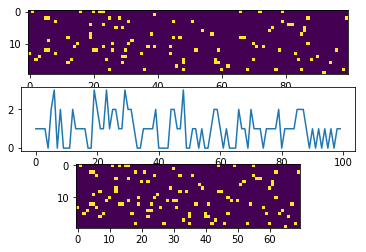

In [20]:
# Now check functions with made up data --This should produce no ensembles!!

cell_len = 20 # number of total cells
num_ensembles = 100 # number of ensembles
ensemble_array = np.zeros((cell_len,num_ensembles)) # 4 cell rows, 10 ensemble columns


# Dummy data, insert 1s in various locations to signify firing/activation

ind1 = np.random.choice(np.arange(cell_len), 100)
ind2 = np.random.choice(np.arange(num_ensembles),100)
ensemble_array[ind1,ind2] = 1
#plt.subplot(311)
#plt.imshow(ensemble_array)

# remove columns that don't fire
ind = np.where(np.sum(ensemble_array,axis=0)!=0)[0]
ensemble_array = ensemble_array[:,ind]

#plt.subplot(312)
#plt.plot(np.sum(ensemble_array,axis=0))

#plt.subplot(313)
#plt.imshow(ensemble_array)
#print ensemble_array.shape


verbose = True


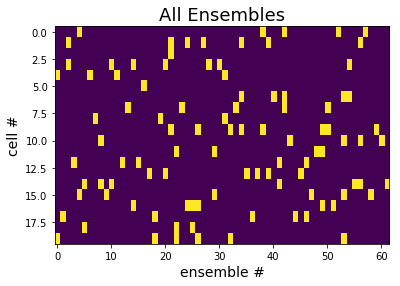

('Total number of permutations ', (1891,))
('zip permutations example of first 300: ', [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (4

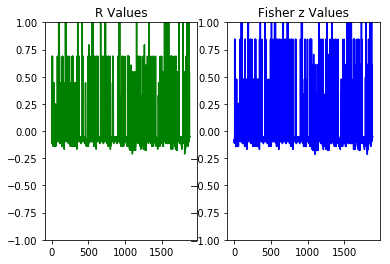

/opt/conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


('Elapsed surrogate time (s): ', 96.85866618156433)

('Pairs above threshold (z): ', (1, 2))
[[56]
 [ 8]]

('Fisher-z values above threshold: ', (1,))
[ 1.08079047]


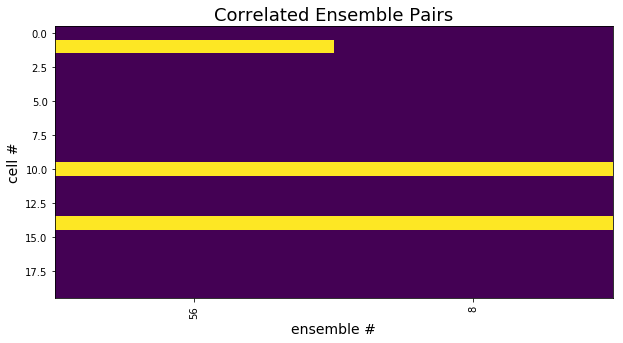

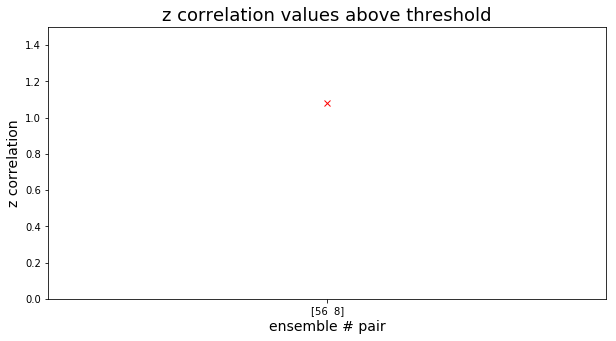

In [16]:
ensemble_pairs,ensemble_pair_indices,z_values = correlations_between_ensembles(ensemble_array,500,99,verbose=True)


In [7]:
ind


(array([], dtype=int64),)

## Load Sample Data and Find Correlations

Keys: [u'cellID', u'ensembles', u'time']
(139, 135)


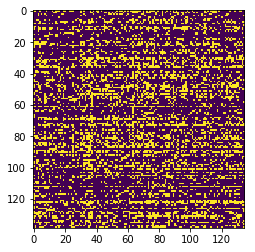

('Number of cells: ', 139)


In [17]:
# Load data from Katie and run functions

import h5py

#f = h5py.File('/home/jacobp/SWDB_2017/DynamicBrain/Project/VISrl_Rbp4_B_580124131_ensembles.h5','r')
#time = f['time_ns'][:]
#ensembles = f['ensembles_ns'][:]
#cellID = f['cellID_ns'][:]

f = h5py.File('/home/jacobp/SWDB_2017/DynamicBrain/Project/546341286_experiment_ensembles.h5','r')
time = f['time'][:]
ensembles = f['ensembles'][:]
cellID = f['cellID'][:]

print("Keys: %s" % f.keys())
f.close()

%matplotlib inline
print ensembles.shape
plt.imshow(ensembles)
plt.show()
print('Number of cells: ',cellID.shape[0])


verbose = True


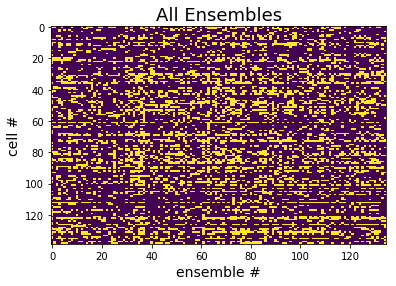

('Total number of permutations ', (9045,))
('zip permutations example of first 300: ', [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 0), (97, 0), (98, 0), (99, 0), (100, 0), (101, 0), (102, 0), 

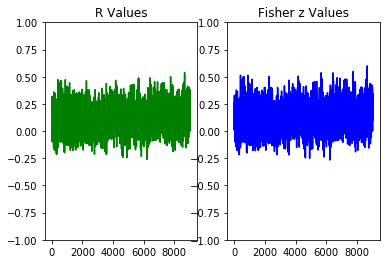

('Elapsed surrogate time (s): ', 528.7488930225372)

('Pairs above threshold (z): ', (2176, 2))
[[  4  17  18 ..., 131 132 132]
 [  0   0   0 ..., 130 130 131]]

('Fisher-z values above threshold: ', (2176,))
[ 0.32845628  0.23308109  0.26160617 ...,  0.3521284   0.30311508
  0.3516675 ]


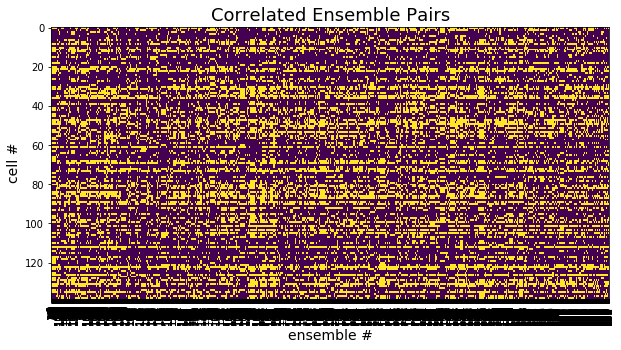

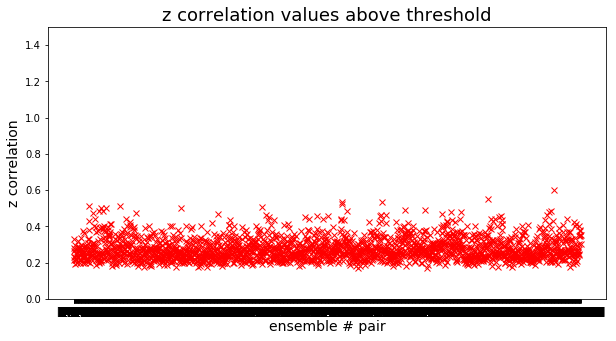

In [18]:
# Check correlations between ensembles - This is the bulk of the algorithm

ensemble_pairs,ensemble_pair_indices,z_values = correlations_between_ensembles(ensembles,500,99,verbose=True)


## Find cliques of ensembles and core ensembles

First 50 Pairs: 
[(4, 0), (17, 0), (18, 0), (19, 0), (25, 0), (28, 0), (31, 0), (32, 0), (33, 0), (37, 0), (42, 0), (47, 0), (50, 0), (52, 0), (61, 0), (62, 0), (63, 0), (65, 0), (66, 0), (69, 0), (72, 0), (75, 0), (77, 0), (79, 0), (84, 0), (86, 0), (92, 0), (95, 0), (96, 0), (104, 0), (110, 0), (114, 0), (115, 0), (123, 0), (125, 0), (127, 0), (128, 0), (129, 0), (130, 0), (131, 0), (2, 1), (3, 1), (6, 1), (32, 1), (67, 1), (69, 1), (81, 1), (84, 1), (85, 1), (101, 1)]
('Full size of pairs:', 2176)

('Elapsed time:', 0.07226085662841797)
('Number of cliques: ', 5526)

The first few cliques: (clique # in first column)
[0, [1, 32, 84, 67, 101, 69, 85]]
[1, [1, 32, 84, 6, 117]]

('Shape of sample ensemble: ', (139, 7))
('Example percentile cutoff: ', 5.2000000000000028)

('Number of core ensembles, same as number of cliques: ', 5526)
('Number of unique core ensembles: ', 5108)
CE_final Original top 3:
[[48, 86, 89, 101, 105, 112, 122, 135, 137], [30, 31, 47, 49, 61, 89, 112, 122, 126, 1

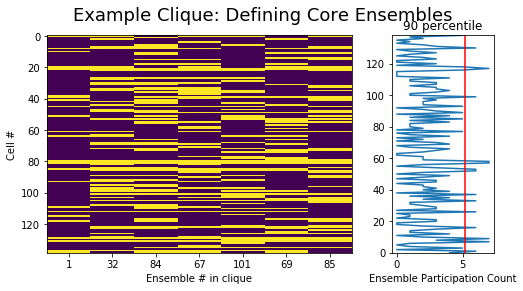

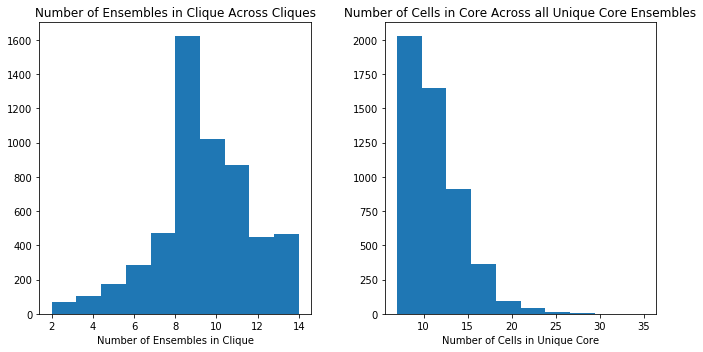

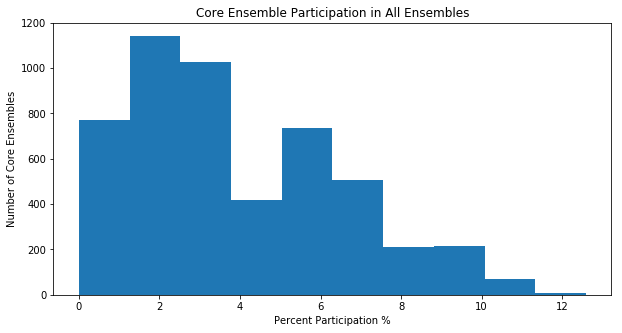

In [19]:
# THIS FUNCTION FINDS CLIQUES FROM CORRELATED PAIRS
cliques = get_correlation_cliques(ensembles,ensemble_pair_indices,verbose=True)

# Get the unique sets of "Core" Ensembles
CE_final = get_unique_core_ensembles(ensembles,cliques,95)

##  Summary Statistics for cliques, Core Ensembles
CE_sorted_by_participation, CE_sorted_by_size, clique_summary, core_summary, percent_participation = summary_stats(ensembles,cliques,CE_final,verbose=True)
